# CS 506 HW1 Solution
Name:

### 1. Understandking K-means Clustering

(Please fill out the functions in k_means_clustering.py)

### 2. Working with the Algorithms

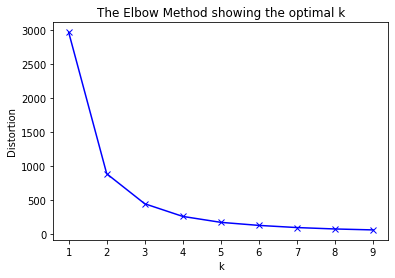

In [1]:
from typing import List, Dict, Tuple
# feel free to add more functions such as discard missing examples

'''
Splits csv manually by rows and columns
:param mat: listings.csv as a list
:return: X: listings.csv parsed into appropriate rows and columns
'''
def split_csv(mat):
    X = []
    row = [] # Row of matrix, add at newlines
    col = "" # Value of each comma separated column within row
    
    # Using FSM inspired approach, if we encounter a single or double quotes, we add the characters no matter what until we encounter another
    # quotation mark. This way, quote should be false at the real end of the line and comma separators
    quote = False # True when within double quotes
    new_col = False # True when we are starting a new column in row
    for char in mat:
        if(new_col):
            # If it is a brand new column, and we have another separator (comma or new line), we skipped over a missing value, so still add it (NaN/""), then continue,
            # from another new column (keep new_col True), o/w set new_col to false and begin adding characters
            if(char == "," or char == "\n"):
                col = ""
                row.append(col)
                if(char == "\n"):
                    X.append(row)
                    row = []
                continue
            new_col = False
        
        if (char == '"' or char == '"'):
            quote = not quote
        
        # Add no matter what when within quotes
        if(quote):
            col += char
            continue;
        # At this point we must not be in quotes
        
        # Must be a column separator
        if(char == ","):
            new_col = True
            row.append(col)
            col = ""
            continue;
        # Else we have to check if we are at the true end of the row ("\n"). If we are, add the whole row, and start a new row
        else:
            if(char != "\n"):
                col += char
            else:
                # New line, add what we have, move to new row
                row.append(col)
                X.append(row)
                col = ""
                row = []
    return X

'''
Reading in airbnb dataset, X has 3 features, latitude and longitude, and price (cols 6,7,9).
:param X: list of lists, airbnb dataset
:return X: features include cols 6,7,9 of X
'''
def extract_csv(mat):
    latitude = [item[6] for item in mat[1:]]
    longitude = [item[7] for item in mat[1:]]
    price = [item[9] for item in mat[1:]]
    X = list(zip(latitude, longitude, price))
    
    return X

'''
Checks and removes rows with NaNs if any
'''
def prune_csv(X):
    i = 0
    while (i<len(X)):
        for j in range(len(X[0])-1):
            if (X[i][j] == "" or X[i][j] != X[i][j]):
                X.pop(i)
                i-=1
                break
        i+=1

    return X


def read_dataset(dataset_path: str = "./data/listings.csv"):
    """
    read in NYC dataset and return a dataset type of your choice
    :param dataset_path: the string path to the dataset file
    :return: dataset
    """
    X = []
    file = open(dataset_path, 'r')
    mat = file.read()
   
    X = split_csv(mat)
    X = extract_csv(X) # [latitude, longitude, price]
    X = prune_csv(X) # Doesn't actually remove anything
    return X


import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import mixture
import matplotlib.pyplot as plt
# Used for the elbow method to determine the number of clusters to use
# Credit to: https://tinyurl.com/sadjkfvx for this function
def elbow_plot(X):
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(X)
        distortions.append(kmeanModel.inertia_)
    
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    return



def cluster_nyc_listings():
    """
    cluster AirBnb listings using k-means++, hierarchical, and GMM
    :return: y_kmeans, y_hierarchical, y_GMM: labels for lmeans, hierarchical, and GMM
    """
    X = read_dataset()
    # First normalize the data (feature scaling)
    np.array(X)
    
    # Normalize data
    X = preprocessing.normalize(X)

    # Determine optimal number of clusters
    elbow_plot(X)
    n_clusters = 3
    # Labels (cluster) for each data point
    # Kmeans++
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    y_kmeans = kmeans.labels_
    # kmeans_centers = kmeans.cluster_centers_
    
    # Hierarchical clustering
    hierarchical_clustering = AgglomerativeClustering().fit(X)
    y_hierarchical = hierarchical_clustering.labels_
    # GMM
    gmm = mixture.GaussianMixture(n_components=n_clusters, covariance_type="full").fit(X)
    y_GMM = gmm.predict(X)
    # gmm_means = gmm.means_
    return y_kmeans, y_hierarchical, y_GMM

# X = read_dataset()
y_kmeans, y_hierarchical,y_GMM = cluster_nyc_listings()

To determine the number of clusters, I decided to use the elbow method which I was familiar with using in previous classes. I used elbow_plot() to help with plotting the data and determined visually that k=3 would be most likely to be optimal. If I hadn't done this, I would've chosen 3 by default, then looked at the clusters visually with different Ks and seen which looked the most visually accurate.

### 2b List a few bullet points describing the pros and cons of the various clustering algorithms.

* Kmeans works well when data is hyper-spherical, whereas Hierarchical clustering will not work well in this case
* GMM is more flexible with large covariance of the data
* Kmeans will always converge, although it may not be to a global minimum
* Kmeans and GMM you have to specify a value for k ahead of time
* GMM allows you to predict the probability a point will be in any cluster, rather than a specific label for each point as with Kmeans
* Kmeans is faster than hierarhical clustering and GMM

### 3 Data Visualization
### 3a Produce a Heatmap. Is this heatmap useful in order to draw conclusions about the expensiveness of areas within NYC? if not, why?

In [2]:
import folium
import pandas as pd
from folium.plugins import HeatMap

def generate_base_map(default_location: Tuple[float, float]=[40.693943, -73.985880]):
    base_map = folium.Map(location=default_location)
    return base_map
   
base_map = generate_base_map()
df = pd.read_csv("./data/listings.csv")

HeatMap(
    data=df[["latitude", "longitude", "price"]]
    .groupby(["latitude", "longitude"])
    .mean()
    .reset_index()
    .values.tolist(),
    radius=8,
    max_zoom=13,
).add_to(base_map)
base_map.save("index.html")
                      

While it is mostly uniform, and doesn't present a great heatmap, we see a clear hotspot around Manhattan which is definitely expected, and if weren't the case would be a clear indicator of something wrong. But, in terms of looking around other neighborhoods, it is pretty hard to judge considering the heatmap is pretty uniform in color, although there are still some hotspots around the map.

### 3b Visualize the clusters by plotting the longitude / lattitude of every listings in a scatter plot

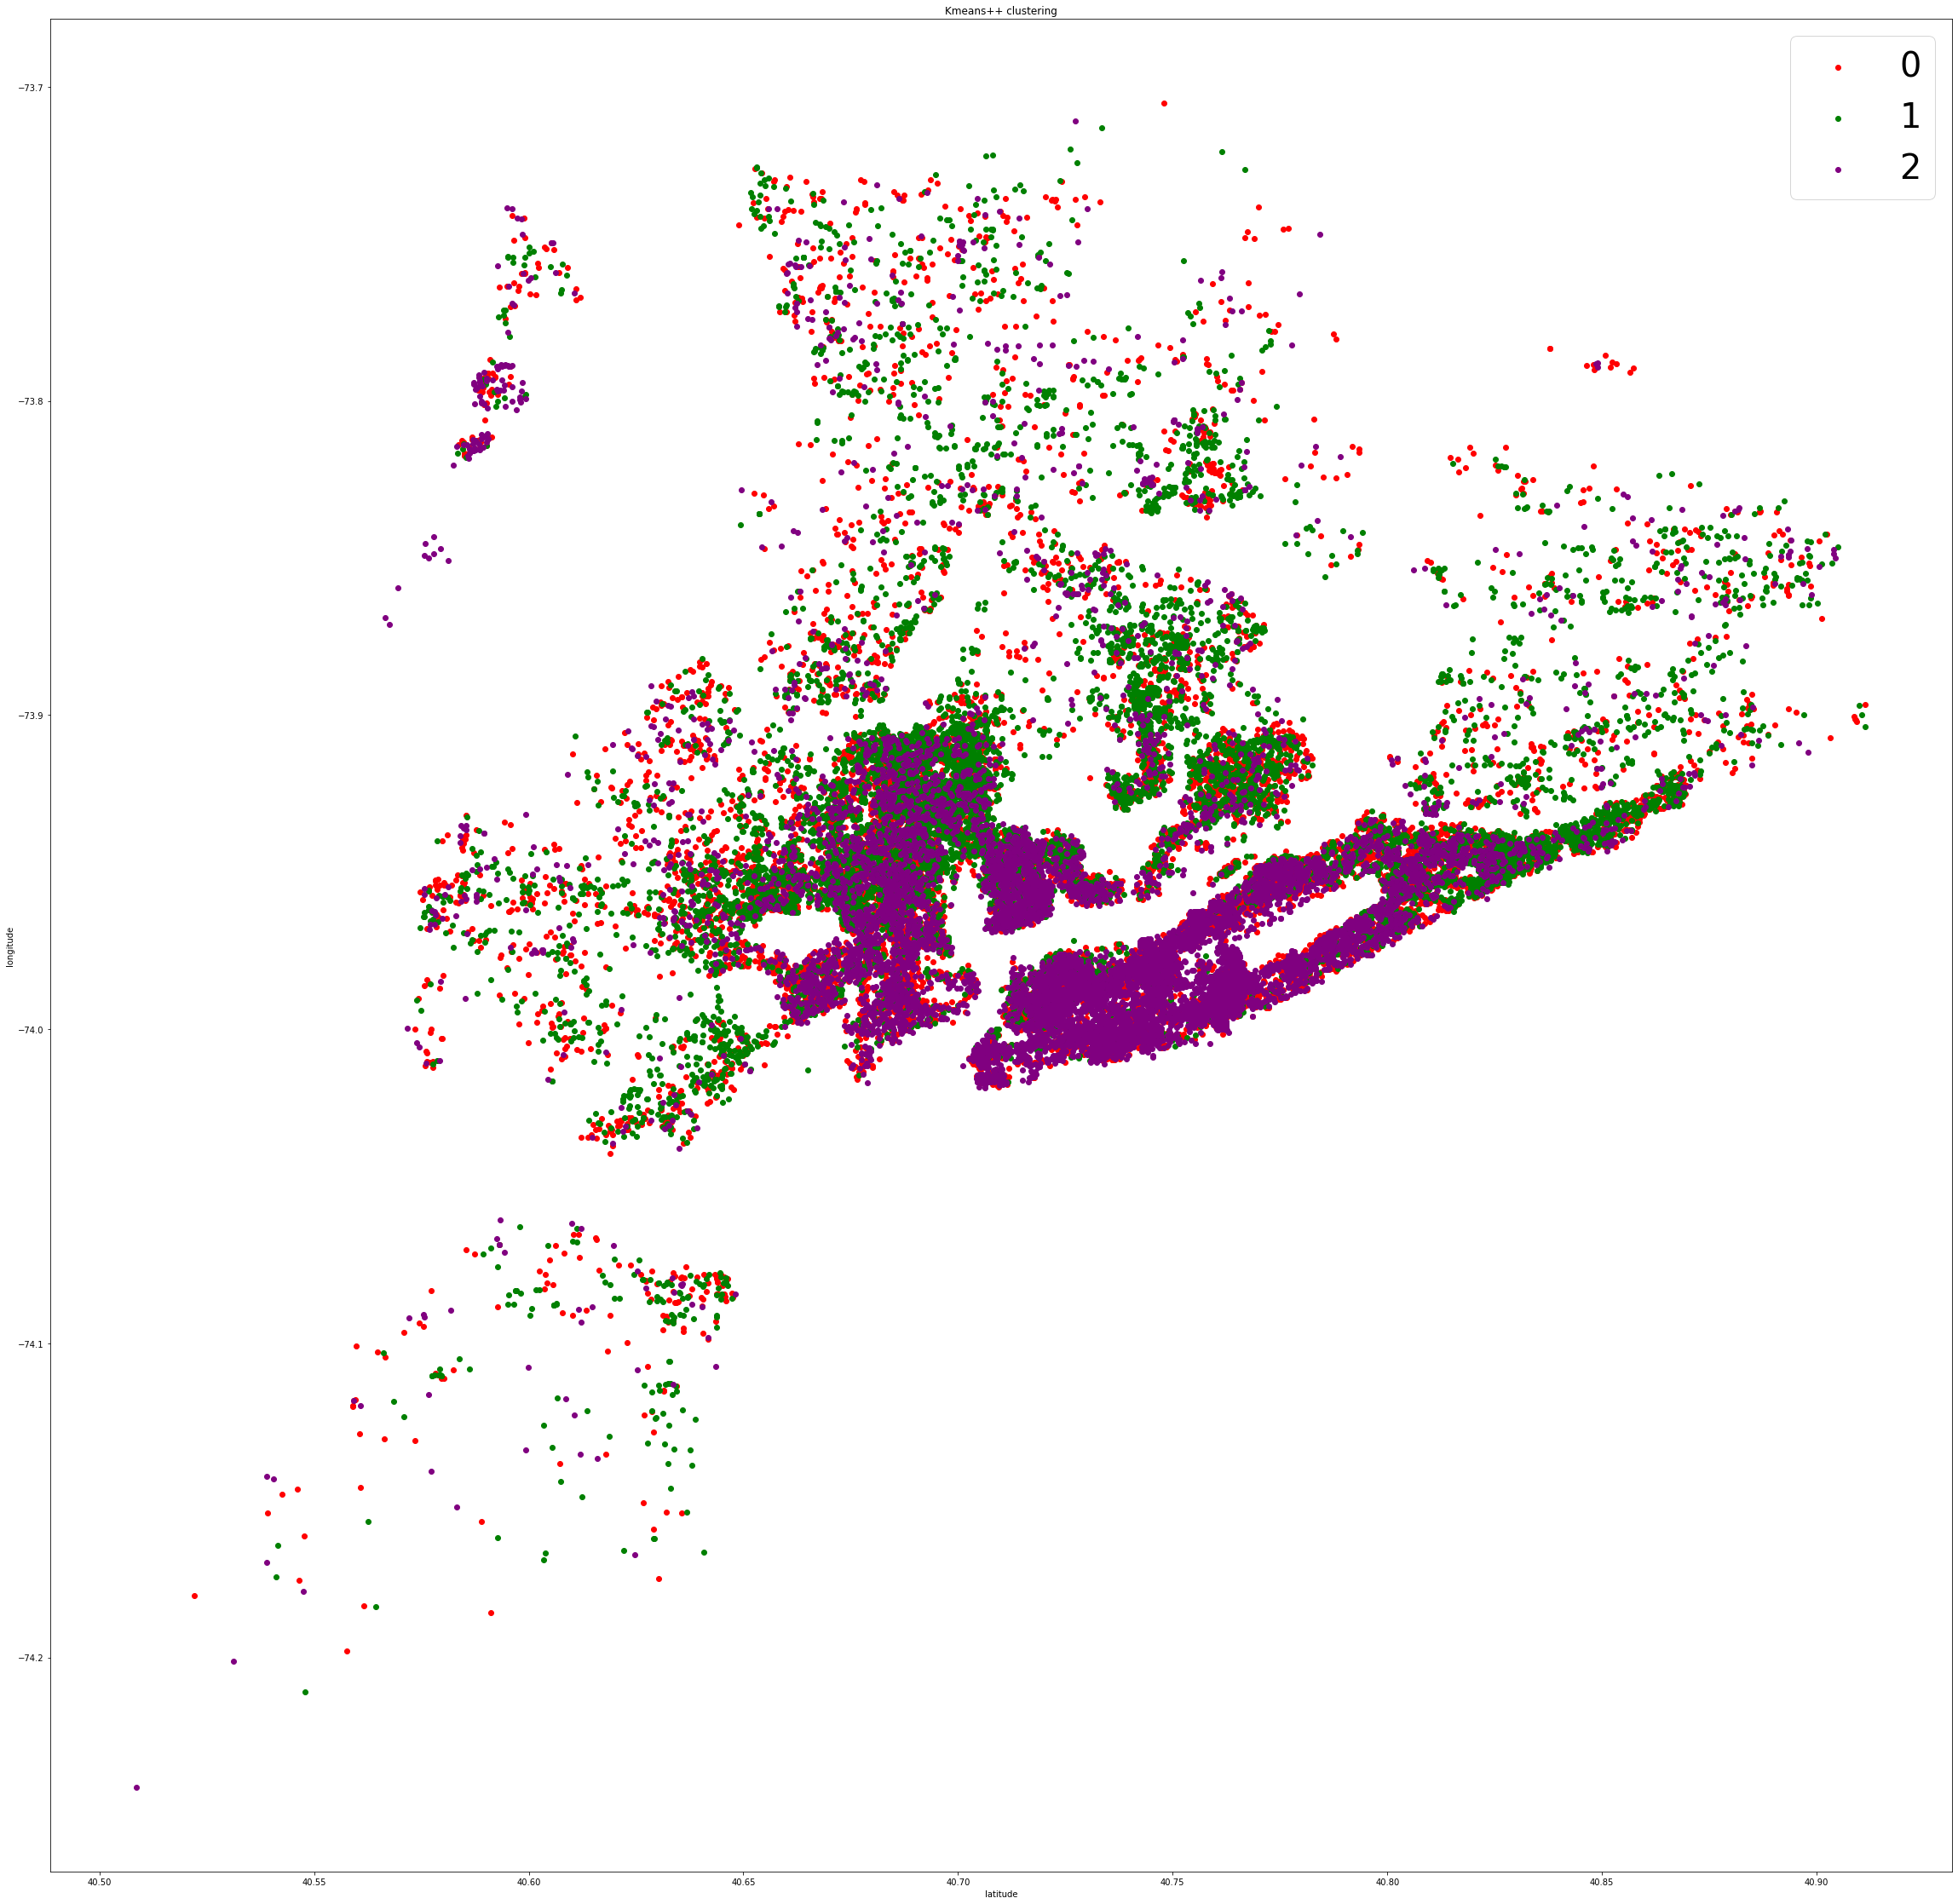

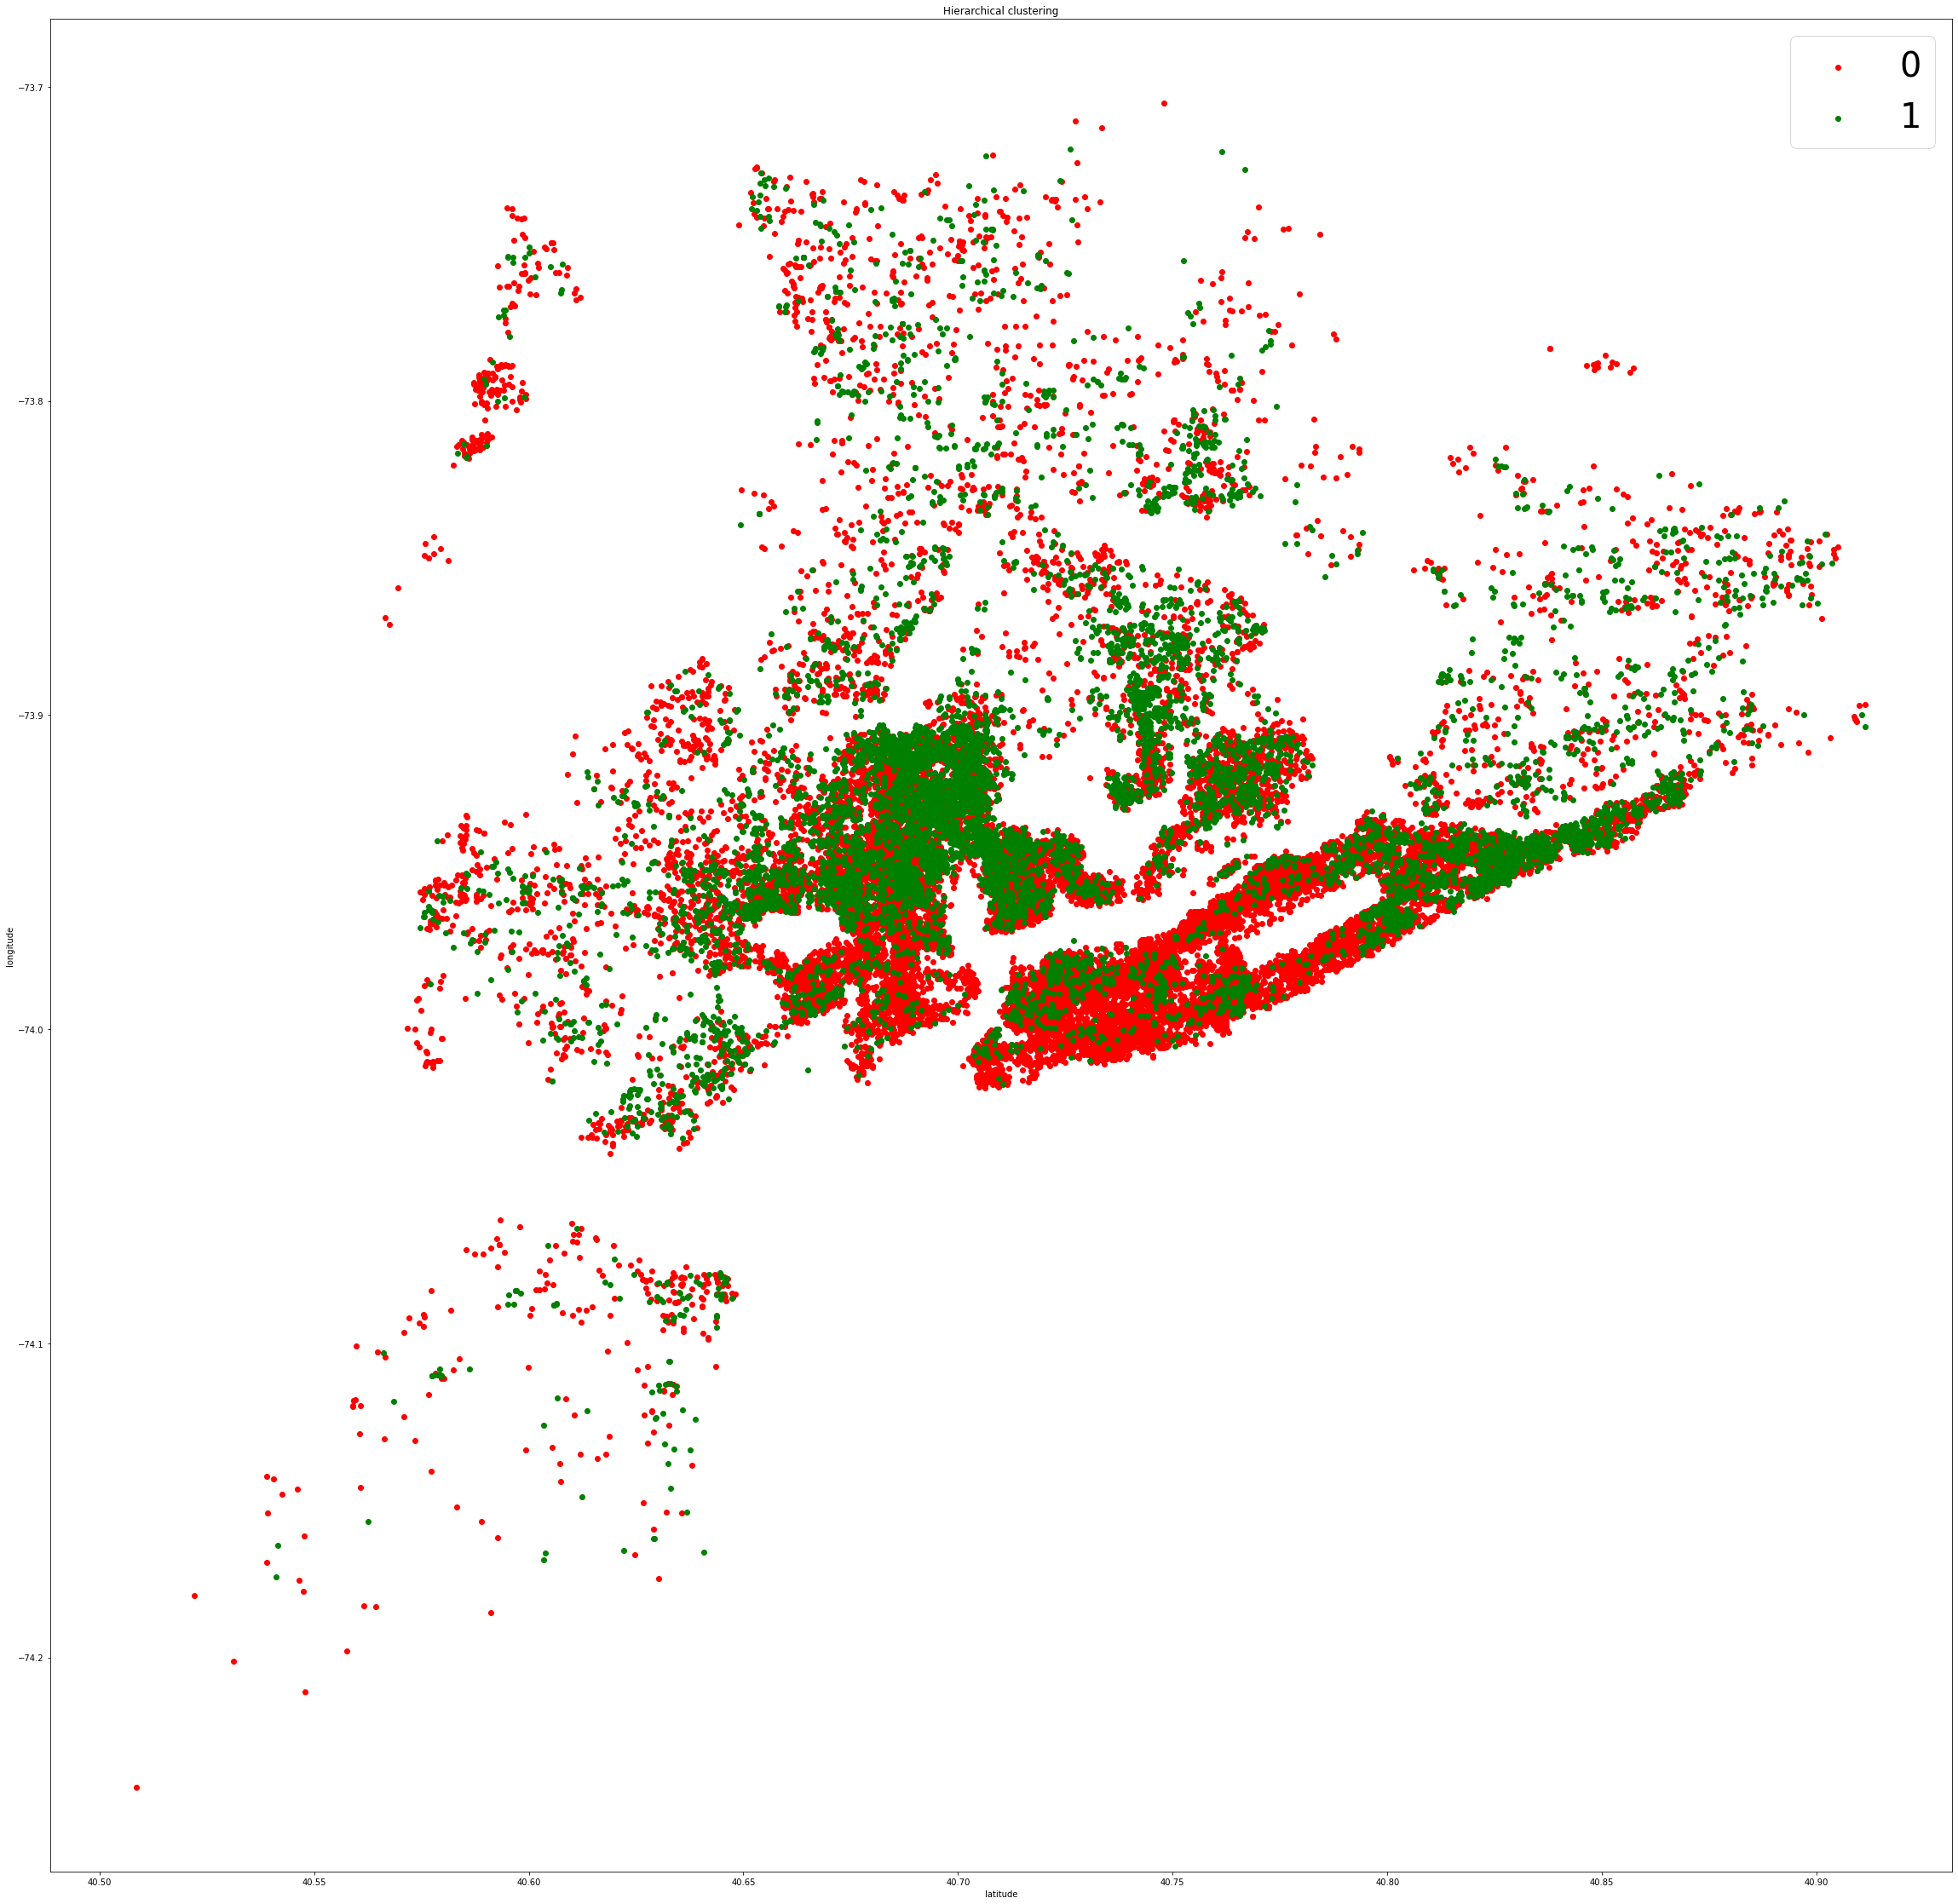

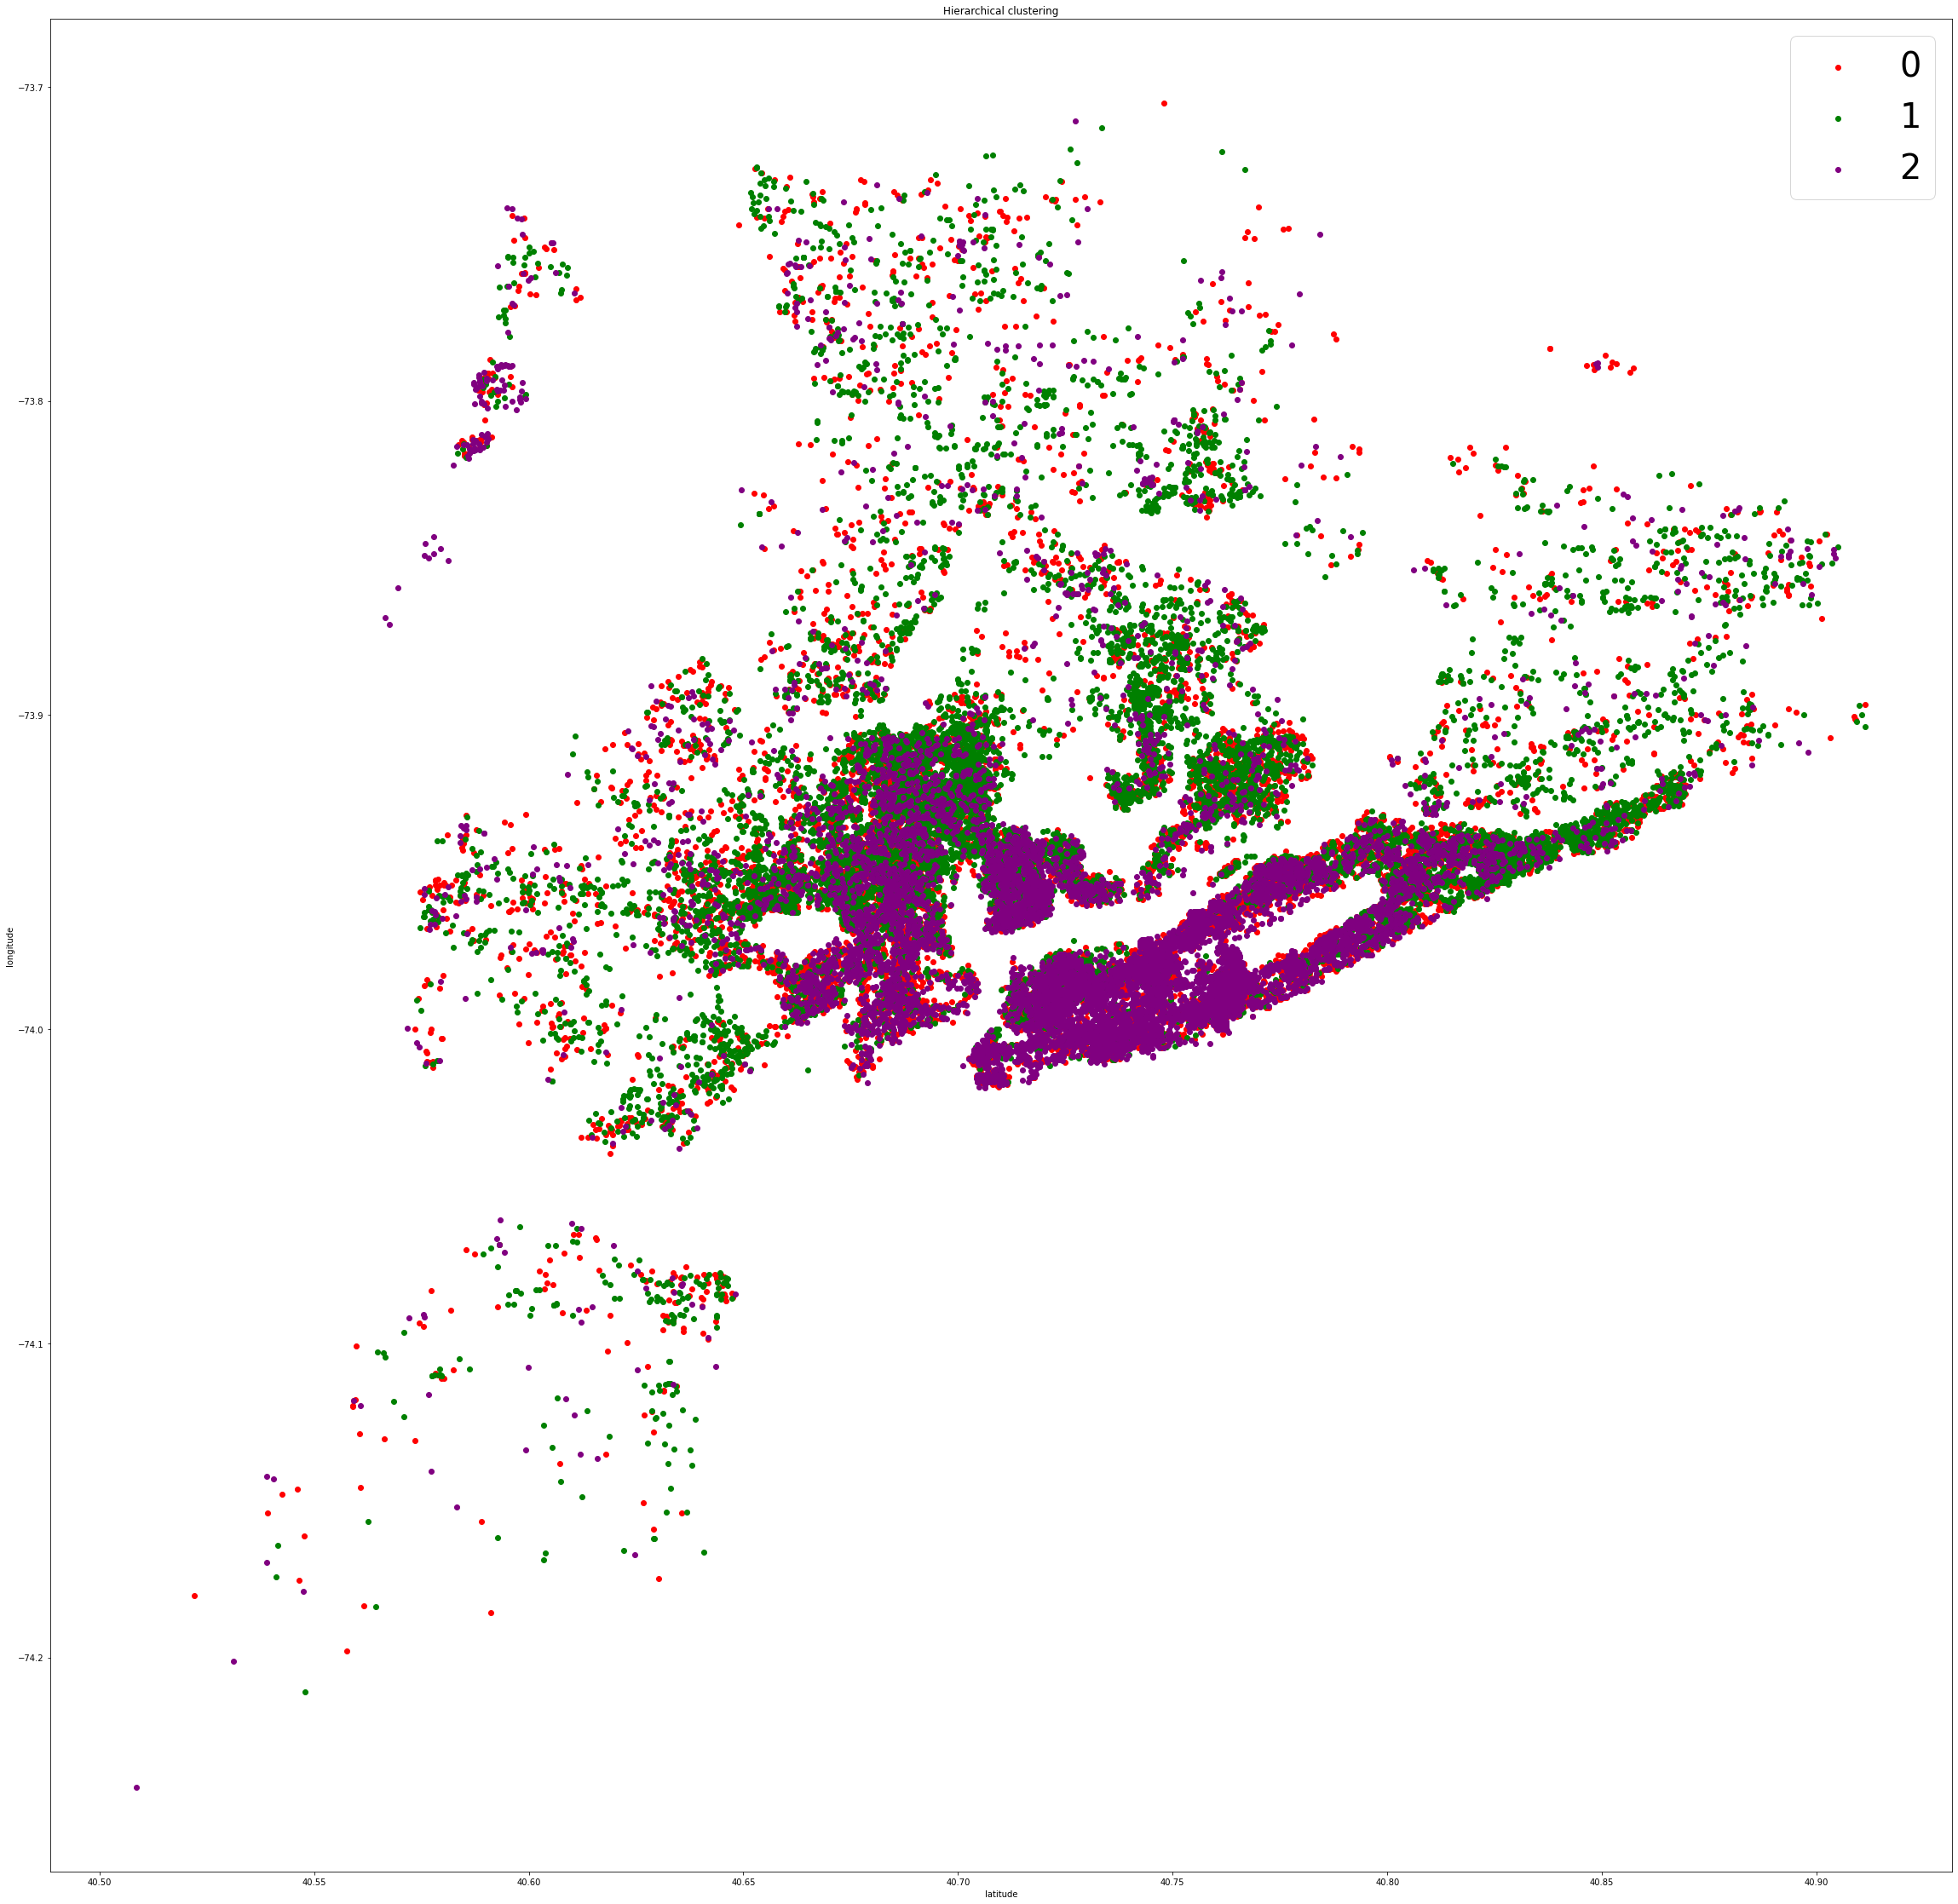

In [66]:
def visualize_clusters():

    data = pd.read_csv("./data/listings.csv")[["latitude", "longitude"]]
    lats = data["latitude"]
    longs = data["longitude"]

    colors = ["red", "green", "purple"]

    # Plot kmeans results
    plt.figure(figsize=(40, 40))
    plt.xlabel("latitude")
    plt.ylabel("longitude")
    plt.title('Kmeans++ clustering')
    for cluster in range(max(y_kmeans)+1):
        plt.scatter(lats[y_kmeans==cluster], longs[y_kmeans==cluster], color = colors[cluster], label=cluster)
    plt.legend(fontsize="40")
    plt.show()
    
    # # Plot Hierarchical results
    plt.figure(figsize=(40, 40))
    plt.xlabel("latitude")
    plt.ylabel("longitude")
    plt.title('Hierarchical clustering')
    for cluster in range(max(y_hierarchical)+1):
        plt.scatter(lats[y_hierarchical==cluster], longs[y_hierarchical==cluster], color = colors[cluster], label=cluster)
    plt.legend(fontsize="40")
    plt.show()

    # # Plot GMM results
  # # Plot Hierarchical results
    plt.figure(figsize=(40, 40))
    plt.xlabel("latitude")
    plt.ylabel("longitude")
    plt.title('Hierarchical clustering')
    for cluster in range(max(y_GMM)+1):
        plt.scatter(lats[y_GMM==cluster], longs[y_GMM==cluster], color = colors[cluster], label=cluster)
    plt.legend(fontsize="40")
    plt.show()



visualize_clusters()

### 3c For every cluster, report the average price of the listings within this cluster

In [4]:
data = pd.read_csv("./data/listings.csv")[["price"]]

# Average price for each cluster, for each clustering method
kmeans_avg = pd.DataFrame(data).groupby(y_kmeans).mean()
hierarchical_avg = pd.DataFrame(data).groupby(y_hierarchical).mean()
gmm_avg = pd.DataFrame(data).groupby(y_GMM).mean()
print("Kmeans average prices: ")
print(kmeans_avg)
print("Hierarchical average prices: ")
print(hierarchical_avg)
print("GMM average prices: ")
print(gmm_avg)

Kmeans average prices: 
        price
0  112.761110
1   53.876074
2  332.552934
Hierarchical average prices: 
        price
0  197.599527
1   48.981218
GMM average prices: 
        price
0  118.780621
1   56.915206
2  342.489866


### 3d Bonus point (provide a plot on an actual NYC map)

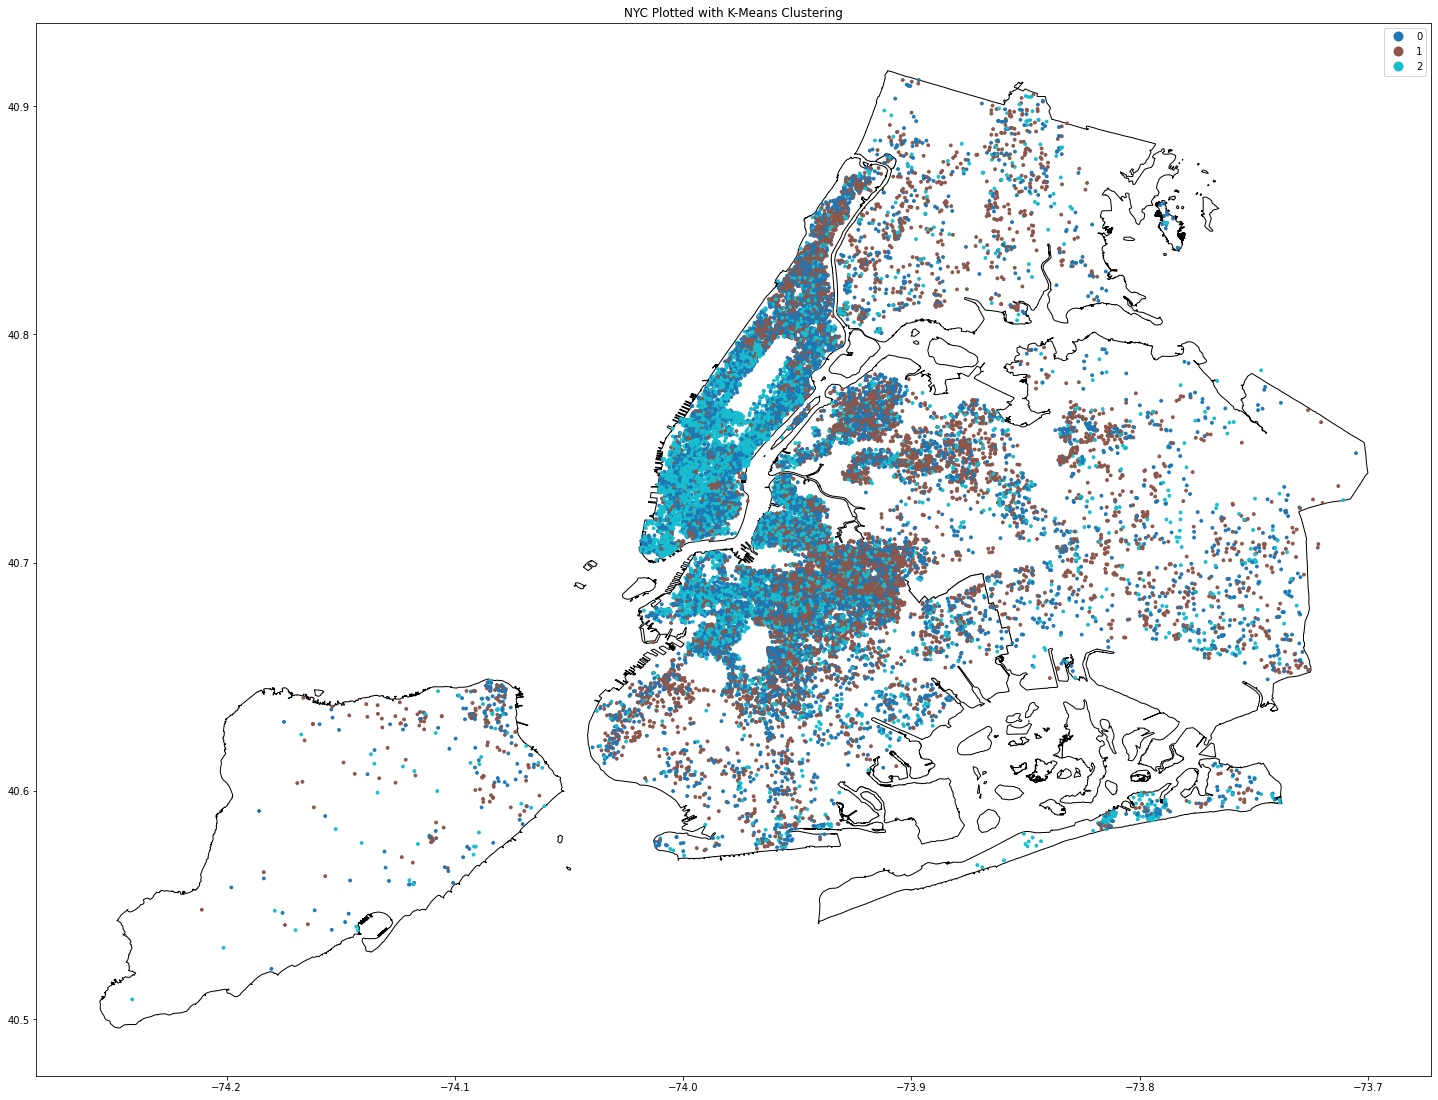

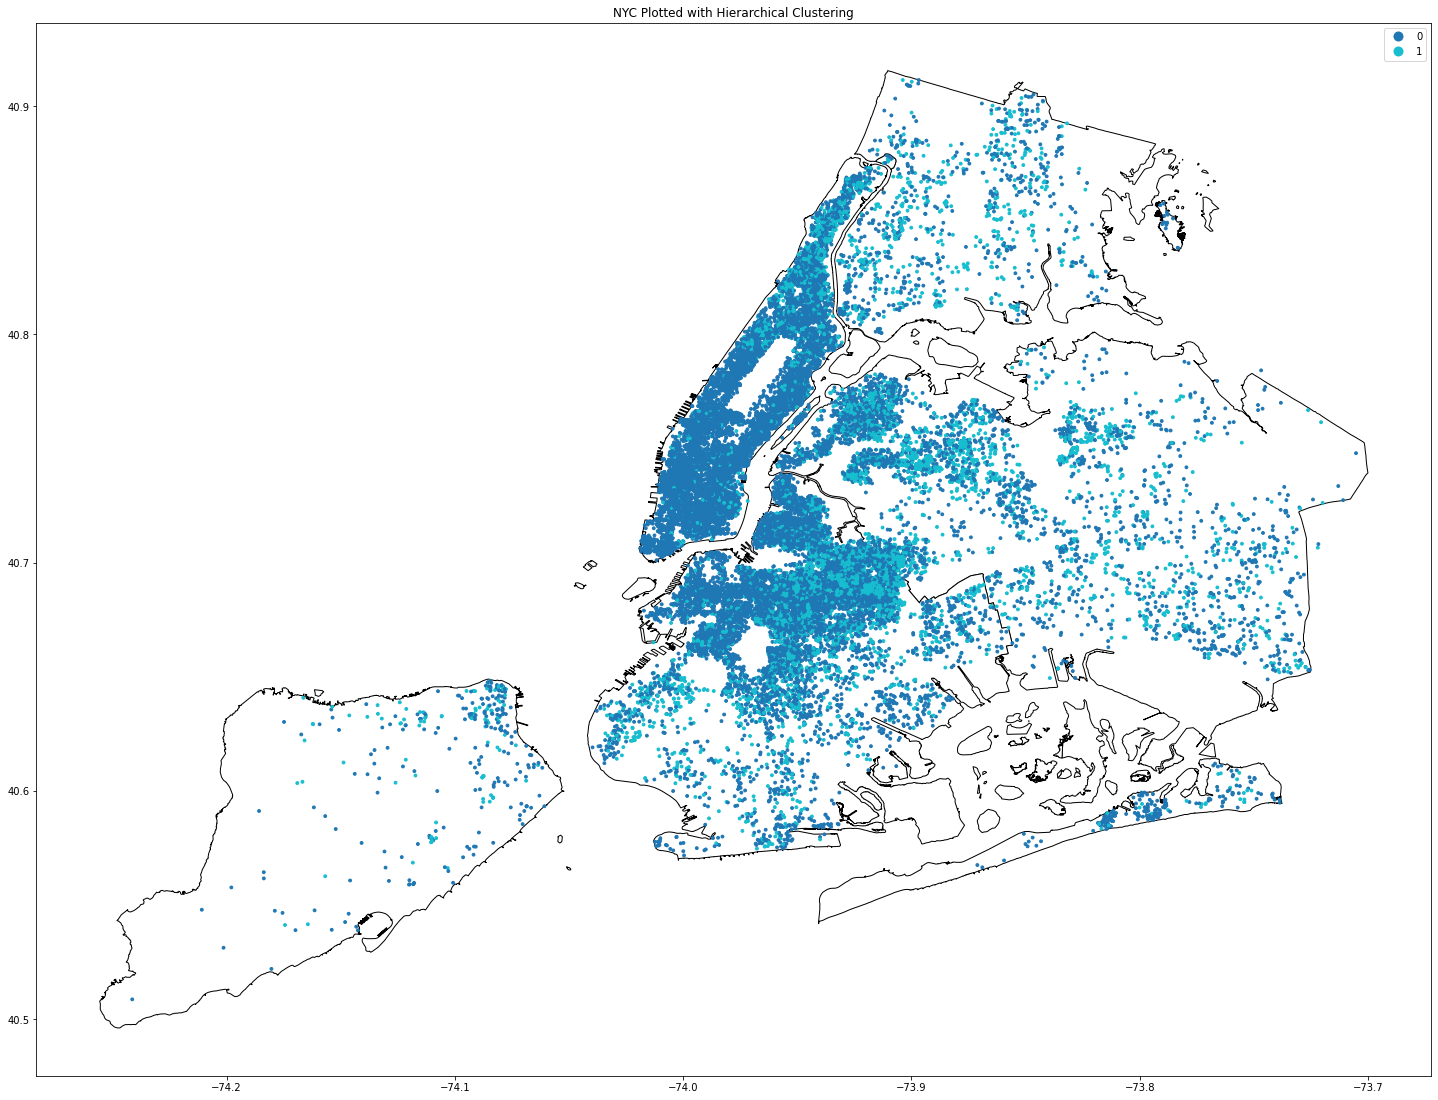

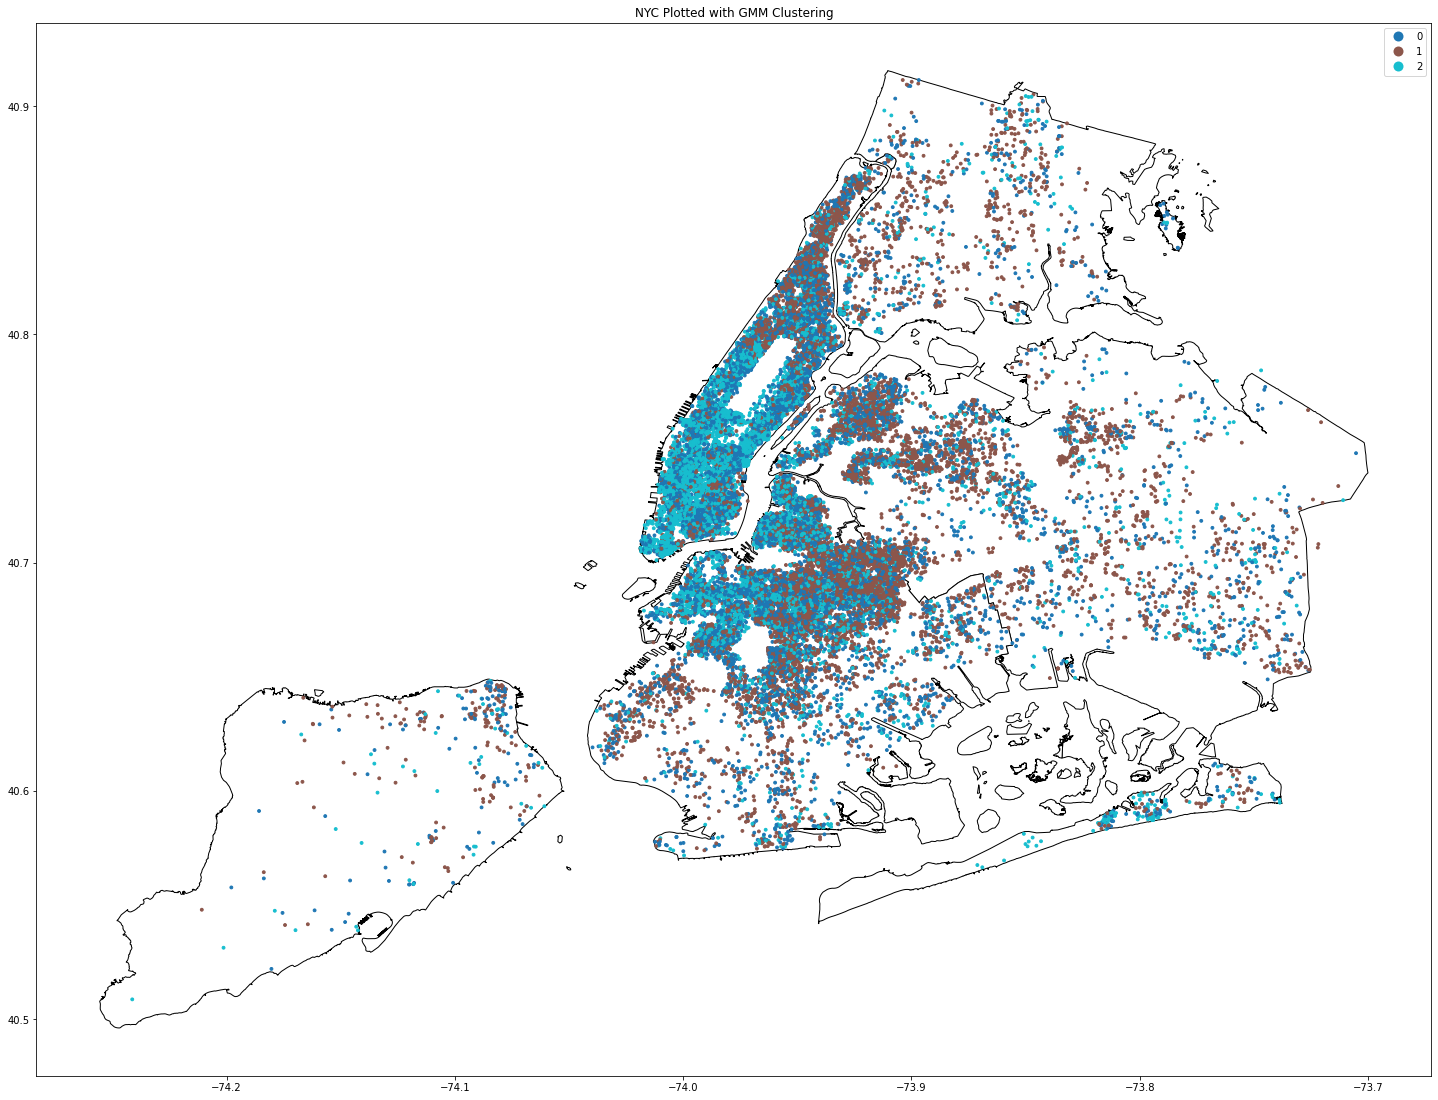

In [84]:
import geopandas as gpd
# Help from geopandas docs: https://tinyurl.com/22xrsx5r
def visualize_on_map():
    # gdf = gpd.read_file(gpd.datasets.get_path('nybb'))

    data = pd.read_csv("./data/listings.csv")[["latitude", "longitude"]]
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(data.longitude, data.latitude))

    # Plot kmeans results
    ax = gpd.read_file(gpd.datasets.get_path('nybb')).to_crs(4326).plot(color='white', edgecolor='black', figsize=(25, 25))
    gdf.plot(ax=ax, column=y_kmeans, label=y_kmeans, legend=True, categorical=True, markersize=8)
    plt.title("NYC Plotted with K-Means Clustering")
    plt.show()

    # # Plot Hierarchical results
    ax = gpd.read_file(gpd.datasets.get_path('nybb')).to_crs(4326).plot(color='white', edgecolor='black', figsize=(25, 25))
    gdf.plot(ax=ax, column=y_hierarchical, label=y_hierarchical, legend=True, categorical=True, markersize=8)
    plt.title("NYC Plotted with Hierarchical Clustering")
    plt.show()

    # # Plot GMM results
    ax = gpd.read_file(gpd.datasets.get_path('nybb')).to_crs(4326).plot(color='white', edgecolor='black', figsize=(25, 25))
    gdf.plot(ax=ax, column=y_GMM, label=y_GMM, legend=True, categorical=True, markersize=8)
    plt.title("NYC Plotted with GMM Clustering")
    plt.show()


visualize_on_map()

### 3e Are the findings in agreement with what you have in mind about the cost of living for neighborhoods in NYC? If you are unfamiliar with NYC, you can consult the web.

Considering that the most dense area of expensive clusters is in Manhattan, it is definitely at least somewhat in agreement with my assumptions of the cost of living in NYC.

### 4. Image Manipulation

In [1]:
# You need to add more functions here
import cv2
from k_means_clustering import run_k_means, choose_random_centroids

def display_image(image):
    cv2.imshow("Display Window", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

def cluster_image(image_path: str):
    # read in image
    image = cv2.imread(image_path)

    # k means cluster image and reassign pixel value

    X = image.reshape((-1,3)) # flatten

    clusters, centroid_history = run_k_means(X, choose_random_centroids(X, K=10), n_iter=5)
    centroids = centroid_history[len(centroid_history)-1]
    
    for i, cluster in enumerate(clusters):
        X[i] = centroids[int(cluster)]


    X = X.reshape(image.shape)
    
    # Save image
    cv2.imwrite("./p4_image_out.png", X)
    display_image(X)

    return

cluster_image("data/image.jpg")

Iteration 0, Finding centroids for all samples...
Recompute centroids...
Iteration 1, Finding centroids for all samples...
Recompute centroids...
Iteration 2, Finding centroids for all samples...
Recompute centroids...
Iteration 3, Finding centroids for all samples...
Recompute centroids...
Iteration 4, Finding centroids for all samples...
Recompute centroids...


The final image for problem 4 was saved to "./p4_image_out.png"